# **Pokémon Diffusion<a id="top"></a>**

> #### ``03-Diffusion-Process.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 24/03/2024</small></i></div>

Como bien se ha descrito antes, el modelo de difusión es un modelo generativo que se basa en la difusión de ruido en una imagen para generar muestras. Este modelo se puede dividir en dos etapas: el modelo en sí y el **proceso de difusión**. En el último notebook se explicó la arquitectura del modelo de difusión, por lo que en este notebook se explicará el proceso de difusión que a su vez se divide en dos partes:

- Difusión hacia adelante ***(Forward Diffusion)***
- Difusión inversa ***(Inverse Diffusion)***. Cada una de estas dos partes, simboliza los dos pasos del modelo de difusión: añadir ruido a la imagen de entrada y eliminar el ruido de la imagen resultante. 

Todo ello siguiendo una ***cadena de Markov***, donde el proceso de **forward diffusion** se puede describir como: $p(x_{t} | x_{t-1})$, la distribución de probabilidad de la imagen en el paso de tiempo $t$ dado el paso de tiempo anterior $t-1$. De modo que la imagen en el paso de tiempo $t$ depende solo de la imagen en el paso de tiempo anterior $t-1$. Y el **inverse diffusion** $q_{\theta}(x_{t-1} | x_{t})$ es la distribución de probabilidad inversa, es decir, la distribución de probabilidad de la imagen en el paso de tiempo $t-1$ dado el paso de tiempo $t$ y de igual manera, la imagen en el paso de tiempo $t-1$ depende solo de la imagen en el paso de tiempo $t$.

<p align="center">
    <img src='../figures/notebook_figures/diffusion_overview.png' width=40% height=50% />
</p>

En cada sección, se explicará el funcionamiento de cada una de las partes del modelo de difusión. Primero, empezaremos definiendo los hiperparámetros del modelo de difusión. Estos hiperparámetros son los que se han usado en los papers [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233) y [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) y se han mantenido para este proyecto.

- ``T``: Número de pasos de difusión, es decir, el número de veces que se añade ruido a la imagen de entrada.

- ``beta_start`` y ``beta_end``: Parámetros que determinan la cantidad de ruido que se añade en cada paso. Un valor más alto de *beta* significa que se añade más ruido, y, por tanto, una mayor diversidad en las muestras generadas, pero también implica una mayor dificultad para el modelo de difusión. *beta_start* es el valor de *beta* en el primer paso y *beta_end* es el valor de *beta* en el último paso. Más adelante se explicará este concepto con más detalle.

- ``s``: el factor de escala de la distribución de ruido. Es decir, determina el desplazamiento aplicado al paso de tiempo "t" durante el proceso de añadir ruido a la imagen. Este desplazamiento modifica la fase de la función coseno, influyendo en la progresión de la varianza desde los pasos de tiempo iniciales hasta los finales, afectando así la suavidad de la transición en los niveles de ruido aplicados durante el proceso de difusión.

---

<span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Se ha optado por darle unos valores bajos de beta ya que en este notebook haremos uso del ``cosine`` *scheduler*. Más adelante explicaremos este concepto.
</small></i>

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)

    - [1.1. Carga de datos](#-1.1.-Carga-de-datos)
    - [1.2. Creación del dataset](#-1.2.-Creación-del-dataset)

- [2. Modelo](#-2.-Modelo)

- [3. Forward Diffusion](#-2.-Forward-Diffusion)

- [4. Inverse Diffusion](#-3.-Inverse-Diffusion)

# 0. Imports

Una vez introducido el proyecto, se importan las librerías necesarias para el desarrollo de este apartado.

---

In [2]:
# Import necessary libraries
# =====================================================================
import configparser
import tensorflow as tf
import random

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.diffusion_model import DiffusionModel

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = int(config_hp["img_size"])
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = int(config_hp["batch_size"])
EPOCHS = int(config_hp["epochs"])
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-03-25 19:59:25.874421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 19:59:25.892266: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# 1. Dataset

TODO

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"

poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

2024-03-25 14:55:51.628155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


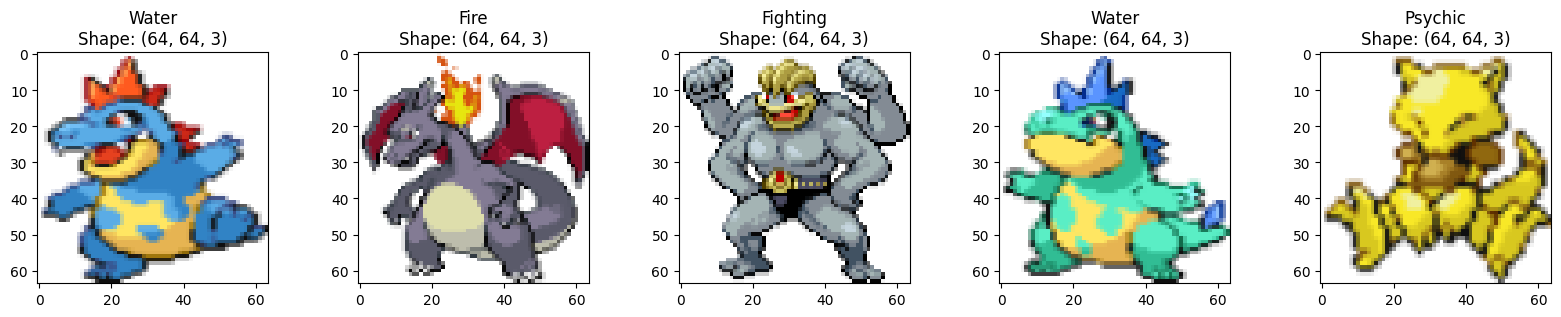

2024-03-25 14:55:53.359196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=5)

# 2. Modelo

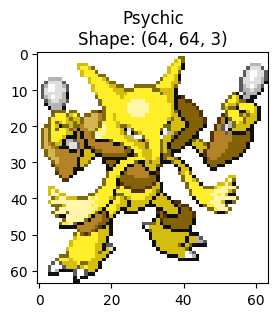

2024-03-25 19:59:31.048108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
one_img_batch = poke_dataset.take(1)

# plot the image
visualize.plot_images_batch(dataset_tf=one_img_batch, n=1)

Generating samples:   0%|          | 0/5 [00:00<?, ?it/s]


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

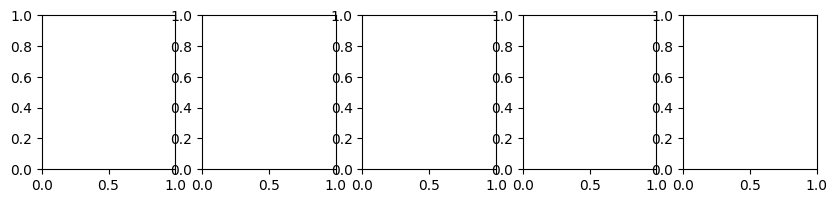

In [6]:
# Imports
# =====================================================================
import configparser
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.utils.utils import string_to_onehot, onehot_to_string, PROJECT_DIR


# Set up
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

IMG_SIZE = int(config["hyperparameters"]["img_size"])
NUM_CLASSES = int(config["hyperparameters"]["num_classes"])
BATCH_SIZE = int(config["hyperparameters"]["batch_size"])
EPOCHS = int(config["hyperparameters"]["epochs"])

TIMESTEPS = int(config["hyperparameters"]["T"])  # Number of diffusion steps
SCHEDULER = config["hyperparameters"]["scheduler"]
BETA_START = float(config["hyperparameters"]["beta_start"])
BETA_END = float(config["hyperparameters"]["beta_end"])
S = float(config["hyperparameters"]["s"])  # Scale factor for the variance curve


class TestDiffusion(tf.keras.Model):
    """
    DiffusionModel class

    Attributes:

    - model (tf.keras.Model): The base model to which the diffusion process is added.
    - img_size (int): The size of the input images.
    - num_classes (int): The number of classes in the dataset.
    - T (int): The total number of diffusion steps.
    - beta_start (float): The starting value of beta (noise level).
    - beta_end (float): The ending value of beta (noise level).
    - s (float): The scale factor for the variance curve in the 'cosine' scheduler.
    - scheduler (str): The type of noise schedule ('cosine' or 'linear').

    Methods:

    - train_step(data): The training step for the diffusion model.
    - predict_step(data): The prediction step for the diffusion model.
    - plot_samples(num_samples, poke_type): Generate and plot samples from the diffusion model.
    - forward_diffusion(x_0, t, T, scheduler, beta_start, beta_end, s): Simulate the forward diffusion process.
    - beta_scheduler(scheduler, T, beta_start, beta_end, s): Generate a schedule for beta values according to the specified type.

    """

    def __init__(
        self,
        model: tf.keras.Model,
        img_size: int,
        num_classes: int,
        T: int,
        beta_start: float,
        beta_end: float,
        s: float,
        scheduler: str,
    ):

        super().__init__()
        self.model = model
        self.img_size = img_size
        self.num_classes = num_classes
        self.T = T
        self.scheduler = scheduler
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.s = s

        self.beta = self.beta_scheduler(scheduler, T, beta_start, beta_end, s)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = tf.math.cumprod(self.alpha)

    def train_step(self, data):
        """
        Algorithm 1: The training step for the diffusion model.

        Args:
            data (tuple): A tuple containing the input data and labels.

        Returns:
            dict: A dictionary containing the training loss.
        """

        # Rename the variables for easier access
        loss_fn = self.loss
        optimizer = self.optimizer
        T = self.T  # Total diffusion steps
        scheduler = self.scheduler
        beta_start = self.beta_start
        beta_end = self.beta_end
        s = self.s  # Scale factor for the variance curve
        alpha_cumprod = self.alpha_cumprod

        # Unpack the data
        input_data, input_label = data

        # 1: repeat ------

        # 3: t ~ U(0, T)
        # Generate a random timestep for each image in the batch
        t = np.random.randint(0, T)
        normalized_t = tf.fill([input_data.shape[0], 1], tf.cast(t, tf.float32) / T)

        # 2: x_0 ~ q(x_0)
        noised_data = self.forward_diffusion(
            input_data,
            t,
            T,
            scheduler,
            beta_start,
            beta_end,
            s,
        )

        # 4: eps_t ~ N(0, I)
        target_noise = noised_data - input_data * tf.sqrt(alpha_cumprod[t]) / tf.sqrt(
            1 - alpha_cumprod[t]
        )

        # 5: Take a gradient descent step on
        with tf.GradientTape() as tape:
            predicted_noise = self.model(
                [noised_data, normalized_t, input_label], training=True
            )
            loss = loss_fn(target_noise, predicted_noise)

        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # 6: until convergence ------

        # Update and return training metrics
        return {"loss": loss}

    def predict_step(self, data):
        """
        Algorithm 2: (sampling) The prediction step for the diffusion model.

        Args:
            data (tuple): A tuple containing the input data and labels.

        Returns:
            tf.Tensor: The final denoised image.

        """

        # Rename the variables for easier access
        T = self.T  # Total diffusion steps
        alpha = self.alpha
        alpha_cumprod = self.alpha_cumprod

        # Starting from pure noise
        x_t, y_t = data  # 1: x_T ~ N(0, I)

        # Reverse the diffusion process
        # 2: for t = T − 1, . . . , 1 do
        for t in tqdm(reversed(range(1, T)), desc="Sampling", total=T - 1, leave=False):
            normalized_t = tf.fill([tf.shape(x_t)[0], 1], tf.cast(t, tf.float32) / T)

            # Sample z
            # 3: z ~ N(0, I) if t > 1, else z = 0
            z = tf.random.normal(shape=tf.shape(x_t)) if t > 1 else tf.zeros_like(x_t)

            # Calculate the predicted noise
            predicted_noise = self.model([x_t, normalized_t, y_t], training=False)

            # Calculate x_{t-1}
            # 4: x_{t-1} = (x_t - (1 - alpha_t) / sqrt(1 - alpha_cumprod_t) * eps_theta) / sqrt(alpha_t) + sigma_t * z
            sigma_t = tf.sqrt(1 - alpha_cumprod[t])
            x_t = (
                x_t - (1 - alpha[t]) / tf.sqrt(1 - alpha_cumprod[t]) * predicted_noise
            ) / tf.sqrt(alpha[t]) + sigma_t * z

        # 5: end for
        # Return the final denoised image
        return x_t  # 6: return x_0

    def plot_samples(self, num_samples: int = 5, poke_type: str = None):
        """
        Generate and plot samples from the diffusion model.

        Args:
            num_samples (int): The number of samples to generate and plot.
            poke_type (str): The type of Pokemon to generate samples for. If None, a random type is chosen.
        """

        _, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))

        # Generate and plot the samples
        # =====================================================================
        for i in tqdm(range(num_samples), desc="Generating samples", total=num_samples):
            # Start with random noise
            start_noise = tf.random.normal([1, self.img_size, self.img_size, 3])

            y_label = np.zeros(NUM_CLASSES)
            y_label = tf.zeros([1, NUM_CLASSES])

            if poke_type is not None:
                poke_type = string_to_onehot(poke_type)
                y_label[poke_type] = 1
            else:
                y_label[np.random.randint(0, NUM_CLASSES - 1)] = 1

            y_label = y_label.reshape(1, NUM_CLASSES)

            # sample = self.predict_step(start_noise, y_label)

            data = (start_noise, y_label)

            sample = self.predict_step(data)

            # Scale to [0, 1] for plotting
            sample = (sample - tf.reduce_min(sample)) / (
                tf.reduce_max(sample) - tf.reduce_min(sample)
            )

            axs[i].imshow(sample[0])
            axs[i].title.set_text(onehot_to_string(y_label))
            axs[i].axis("off")

        plt.show()

    @staticmethod
    def forward_diffusion(
        x_0: tf.Tensor,
        t: int,
        T: int,
        scheduler: str,
        beta_start: float,
        beta_end: float,
        s: float,  # **config["training_params"] TODO
    ) -> tf.Tensor:
        """Simulate the forward diffusion process by adding noise to the input image.

        Args:
            x_0 (tf.Tensor): The initial image tensor.
            t (int): The current timestep.
            T (int): The total number of diffusion timesteps.
            scheduler (str): The type of noise schedule ('cosine' or 'linear').
            beta_start (float): The starting value of beta (noise level).
            beta_end (float): The ending value of beta (noise level).
            s (float): The scale factor for the variance curve in the 'cosine' scheduler.

        Returns:
            tf.Tensor: The diffused image tensor at timestep t.
        """
        # Calculate the noise schedule for beta values
        beta = DiffusionModel.beta_scheduler(
            scheduler=scheduler, T=T, beta_start=beta_start, beta_end=beta_end, s=s
        )
        alpha = 1.0 - beta
        alpha_cumprod = tf.math.cumprod(alpha)

        # Apply the diffusion process: x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1-alpha_cumprod_t) * noise
        noise = tf.random.normal(shape=tf.shape(x_0))
        x_t = tf.sqrt(alpha_cumprod[t]) * x_0 + tf.sqrt(1 - alpha_cumprod[t]) * noise

        return x_t

    @staticmethod
    def beta_scheduler(
        scheduler: str, T: int, beta_start: float, beta_end: float, s: float
    ) -> tf.Tensor:
        """
        Generates a schedule for beta values according to the specified type ('linear' or 'cosine').

        Args:
            scheduler (str): The type of schedule to use. Options are "linear" or "cosine".
            T (int): Total number of timesteps.
            beta_start (float): Starting value of beta.
            beta_end (float): Ending value of beta.
            s (float): Scale factor for the variance curve, used in the 'cosine' scheduler.

        Returns:
            tf.Tensor: The beta values for each timestep.
        """

        if scheduler == "linear":
            beta = tf.linspace(beta_start, beta_end, T)

        elif scheduler == "cosine":

            def f(t):
                return tf.cos((t / T + s) / (1 + s) * tf.constant(np.pi * 0.5)) ** 2

            t = np.arange(0, T + 1)
            alphas_cumprod = f(t) / f(0)
            beta = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
            beta = tf.clip_by_value(beta, 0.0001, 0.999)

        else:
            raise ValueError(f"Unsupported scheduler: {scheduler}")

        return beta


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            # Save the model or do something every 20 epochs
            pass

        if epoch % 10 == 0:
            # Generate and plot samples every 10 epochs
            self.model.plot_samples(num_samples=1)


# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = TestDiffusion(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)


# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)
model.plot_samples(num_samples=5)

# model.fit(one_img_batch, epochs=EPOCHS)
# model.fit(one_img_batch, epochs=EPOCHS, callbacks=[CustomCallback(model)])

In [7]:
DATA_PATH = f"{PROJECT_DIR}/data/processed/pokedex_cleaned.csv"

# Load the dataset
# =====================================================================
import pandas as pd

poke_df = pd.read_csv(DATA_PATH)

In [8]:
from src.utils.utils import label_mapping


def onehot_to_string(one_hot_label: tf.Tensor, df: pd.DataFrame = poke_df) -> str:
    """Converts a one-hot encoded label back to a string

    :param one_hot_label: The one-hot encoded label
    :param df: The dataframe with the pokemon data
    :return: The string label
    """

    dict_df = df.set_index("pokedex_id")["type1"].to_dict()

    label_index = tf.argmax(one_hot_label)
    for label, index in label_mapping(dict_df).items():
        if index == label_index:
            return label


def string_to_onehot(label: str, df: pd.DataFrame = poke_df) -> tf.Tensor:
    """Converts a string label to a one-hot encoded label

    :param label: The string label
    :param df: The dataframe with the pokemon data
    :return: The one-hot encoded label
    """

    dict_df = df.set_index("pokedex_id")["type1"].to_dict()
    len_dict = len(set(dict_df.values()))

    label_index = label_mapping(dict_df)[label]
    one_hot = tf.zeros(len_dict, dtype=tf.int32)

    one_hot = tf.tensor_scatter_nd_update(one_hot, [[label_index]], [1])

    return one_hot


poke_type = "Fire"

# Initialize y_label as a tensor filled with zeros
y_label = tf.zeros([NUM_CLASSES], dtype=tf.int32)

if poke_type is not None:
    type_index = string_to_onehot(poke_type)  # Assuming this returns an integer index
    y_label = tf.tensor_scatter_nd_update(y_label, [[type_index]], [1])

else:
    # Randomly select an index to set to 1
    random_index = tf.random.uniform(
        shape=[], minval=0, maxval=NUM_CLASSES - 1, dtype=tf.int32
    )
    y_label = tf.tensor_scatter_nd_update(y_label, [[random_index]], [1])

# Reshape y_label to have shape (1, NUM_CLASSES)
y_label = tf.reshape(y_label, [1, NUM_CLASSES])

onehot_to_string(y_label)

: 

In [67]:
poke_type = "Fire"

# Initialize y_label as a tensor filled with zeros
y_label = tf.zeros([NUM_CLASSES], dtype=tf.int32)

if poke_type is not None:
    type_index = string_to_onehot(poke_type)  # Assuming this returns an integer index
    y_label = tf.tensor_scatter_nd_update(y_label, [[type_index]], [1])

else:
    # Randomly select an index to set to 1
    random_index = tf.random.uniform(
        shape=[], minval=0, maxval=NUM_CLASSES - 1, dtype=tf.int32
    )
    y_label = tf.tensor_scatter_nd_update(y_label, [[random_index]], [1])

# Reshape y_label to have shape (1, NUM_CLASSES)
y_label = tf.reshape(y_label, [1, NUM_CLASSES])

onehot_to_string(y_label)

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [12]:
poke_type = None

y_label = np.zeros(NUM_CLASSES)


if poke_type is not None:
    poke_type = string_to_onehot(poke_type)
    y_label[poke_type] = 1
else:
    y_label[np.random.randint(0, NUM_CLASSES - 1)] = 1

y_label = y_label.reshape(1, NUM_CLASSES)

0


TypeError: only integer scalar arrays can be converted to a scalar index

In [11]:
# Create the model
# =====================================================================
model = DiffusionModel(
    build_unet(IMG_SIZE, NUM_CLASSES),
    optimizer,
    loss_fn,
    IMG_SIZE,
    NUM_CLASSES,
    T,
    BETA_START,
    BETA_END,
    s,
    SCHEDULER,
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## Forward Diffusion

El proceso de **forward diffusion** se basa en añadir iterativamente ruido a la imagen
de entrada hasta conseguir ruido puro que siga una distribución gaussiana $\mathcal{N}(0, I)$, donde $I$ es la matriz identidad. Este proceso se realiza en $T$ pasos, donde en cada paso se añade una cantidad de ruido determinada por el parámetro $\beta$ a través de un **variance scheduler** que no es más  que la secuencia de $\beta$ que describe la manera en la que se añade ruido a la imagen de entrada dependiendo del instante de tiempo en el que se encuentre hasta llegar a $T$.

<p align="center">
    <img src='../figures/notebook_figures/forward_diffusion.jpeg' width=50% height=50% />
</p>

Cada instante $t+1$ es generado a partir del instante $t$ añadiendo ruido gaussiano a la imagen. Con esto, se consigue cambiar la distribución de datos de los ejemplos del dataset a una gaussiana. Cada eslabón de la cadena de Markov de nuestro modelo corresponde a una distribución distinta. Es decir, la distribución de ruido es una distribución gaussiana con media 0 y varianza $\beta_{t}$, este valor de $\beta_{t}$ es el **diffusion rate** que se calcula para cada instante de tiempo *t* a partir dependiendo del **schedule** que se use, como ya se menciono con anterioridad. 

Por tanto, la distribución de probabilidad de la imagen en el paso de tiempo $t$ dado el paso de tiempo anterior $t-1$ se puede expresar como:

$$p(x_{t} | x_{t-1}) = \mathcal{N}(x_{t} | \sqrt{1 - \beta_{t}}x_{t-1}, \beta_{t}I)$$

Esta fórmula se puede simplificar a través del truco de reparametrización, el renombramiento de $\beta_{t}$ como $\alpha_{t} = 1 - \beta_{t}$ y $\bar{\alpha}_{t} = \prod_{i=1}^{t} \alpha_{i}$ y por recursividad, podemos reescribir la anterior expresión como:

$$x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1 - \bar{\alpha}_{t}}\epsilon_{t}$$

Con este proceso conseguiremos obtener una imagen en cualquier instante de tiempo $t ,,0 <= t <= T$ de la difusión, para posteriormente poder realizar el proceso inverso.

Para lograr esto, se han definido varias funciones. La función principal, ``forward_diffusion()`` se encarga de realizar la difusión hacia adelante implementando lo comentado con anterioridad. Para ello, primero define el valor $\beta$ a través de ``beta_schedule()``. Esta función se encarga de calcular el valor de $\beta$ en cada paso de difusión. Tenemos dos opciones para calcular el valor de $\beta$:
- ``linear`` que añade ruido de manera lineal.
- ``cosine`` que añade ruido de manera más suave al principio y más abrupta en el medio.
   
En este caso, se ha optado por usar ``cosine`` ya según el paper original, se obtienen mejores resultados. Esto se debe a que la función coseno es más suave que la lineal, por lo que la transición entre los niveles de ruido aplicados en cada paso de difusión es más suave. Esto permite que el modelo de difusión aprenda de manera más eficiente y estable, y, por tanto, genere muestras de mayor calidad, pues a partir de algo más de la mitad de los pasos, niveles de ruido usando ``linear`` son muy altos, es decir ya son imágenes muy ruidosas, y esto hace que el modelo de difusión tenga más dificultad para aprender, pues son redundantes y destruye la información de la imagen original muy rápido.

Para calcular el scheduler del coseno, se usa la siguiente fórmula:

$$\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad f(t) = \cos \left( \frac{t/T + s}{1 + s} \cdot \frac{\pi}{2} \right)^2,  \beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}.
$$

En la práctica, limitamos a **$\beta$** para que no sea mayor que 0.999 para prevenir singularidades al final del proceso de difusión cerca de $t = T$.

Una vez definido el valor de **$\beta$**, se procede a calcular el valor acumulado de **$\alpha$** en cada paso de difusión y a generar el ruido que se añadirá a la imagen de entrada. Finalmente, se devuelve la imagen de entrada con el ruido añadido. Esto se hace siguiendo la fórmula anteriormente comentada, que nos permite calcular una imagen en un instante de tiempo *t* cualquiera a partir de la imagen original sin necesidad de iterar todo el rato hasta llegar a ese instante de tiempo, lo cual hace que nos ahorremos mucho tiempo de entrenamiento. ($x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1 - \bar{\alpha}_{t}}\epsilon_{t}$)

---

<i><small>**Más información** sobre como se consigue esta fórmula en el artículo [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

<span style="color: red; font-size: 1.5em;">&#9888;</span> **NOTA:** El proceso matemático para llegar a esta fórmula es muy complejo para explicarlo en este notebook. Sin embargo, en el futuro informe se explicará con más detalle. </small></i>

Para ayudar a visualizar este proceso de difusión directa, usaremos:
- ``plot_noise_levels()`` mustra una gráfica donde se ve como se va añadiendo ruido hasta obtner un ruido total. 
- ``plot_forward_diffusion()`` muestra dicho proceso gráficado pero con un imagen en distintos intasntes de tiempo.

Estas funciones hacen uso de los métodos ``forward_diffusion()`` y ``beta_schedule()`` descritos anteriormente. Y se hacen tanto como para ``linear`` como para ``cosine``. Todo ello, con el objetivo de ilustrar la justificación del uso de ``cosine``.

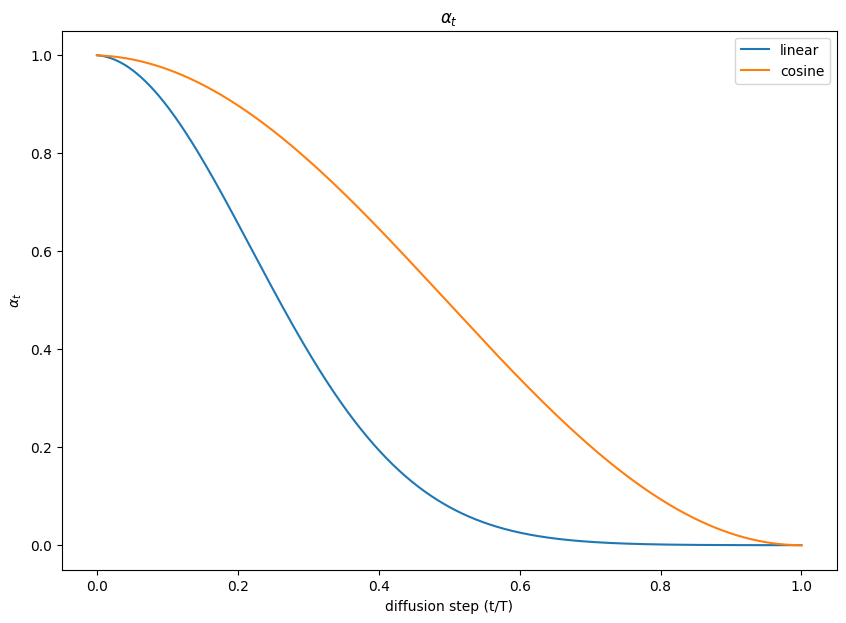

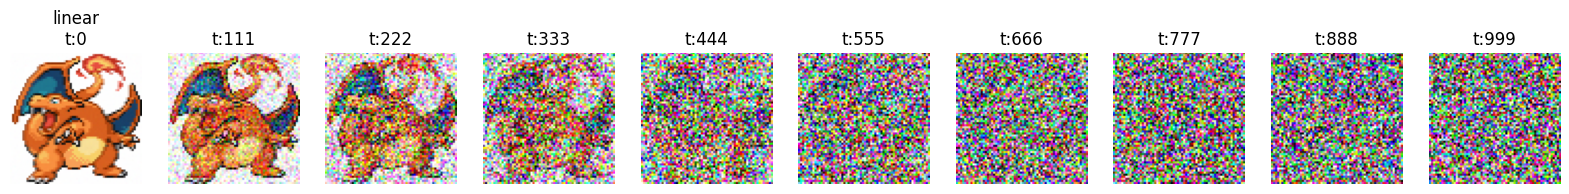

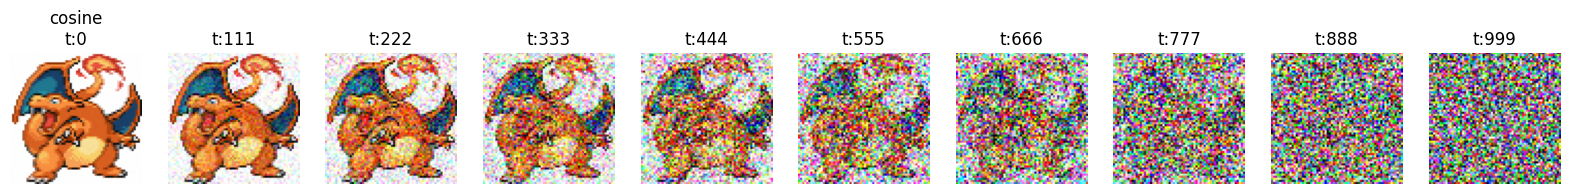

In [5]:
# Plot all the noise levels in the same plot
# =====================================================================
visualize.plot_noise_levels(T, BETA_START, BETA_END, s)

# Plot the forward diffusion function
# =====================================================================
X_train = poke_dataset.map(lambda x, y: x)  # Get the images from the dataset
random_image = next(iter(X_train))[random.randint(0, BATCH_SIZE)]

visualize.plot_forward_diffusion(random_image, "linear", 10, T, BETA_START, BETA_END, s)
visualize.plot_forward_diffusion(random_image, "cosine", 10, T, BETA_START, BETA_END, s)

Como hemos dicho anteriormente, uno de los hiperparámetros más importantes del modelo de difusión es el ``scheduler``. Este hiperparámetro determina la forma en la que se añade el ruido en cada paso de difusión. En este caso, se ha optado por usar ``cosine`` ya según el paper original, se obtienen mejores resultados.

## Inverse Diffusion

El proceso de **inverse diffusion** se encarga de revertir el proceso de forward diffusion, es decir, parte del ruido puro generado en el último paso de la difusión y, paso a paso, reduce este ruido para reconstruir la imagen original o generar nuevas muestras. Este proceso también se realiza en $T$ pasos, pero a la inversa, comenzando desde $t = T$ hasta llegar a $t = 0$.

La idea es aprender una aproximación de la distribución inversa $q(x_{t-1} | x_{t})$ utilizando un modelo parametrizado con una red neuronal. Dado que esta distribución también es gaussiana para valores de $\beta_t$ suficientemente pequeños, podemos parametrizar directamente la media y la varianza de esta distribución y usarla para muestrear el paso previo en la cadena de Markov. Esto es matemáticamente equivalente a predecir el ruido añadido a la imagen en el paso de tiempo $t$ para generar la imagen en el paso de tiempo $t-1$. El porqué del uso de una red neuronal para este proceso, es que, a diferencia del forward process, no podemos usar $q(x_{t-1} | x_{t})$ para revertir el ruido, ya que es incalculable (intratable).

<p align="center">
    <img src='../figures/notebook_figures/inverse_diffusion.webp' width=50% height=50% />
</p>

Para el proceso de reverse diffusion, cada imagen $x_{t-1}$ se genera a partir de la imagen en el instante $t$ aplicando el modelo aprendido para predecir el ruido que fue añadido en el paso de forward diffusion. La fórmula empleada para realizar este proceso se puede definir como:

$$q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1} | \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))$$

- Donde $\mu_{\theta}$ y $\Sigma_{\theta}$ son la media y varianza aprendidas por la red neuronal. Tal que:

\begin{align*}
\mu_{\theta}(x_{t}, t) &:= \tilde{\mu}_{t}(x_{t}, x_{0}) \\
\Sigma_{\theta}(x_{t}, t) &:= \tilde{\beta}_{t} I
\end{align*}

El modelo de reverse diffusion se entrena para **minimizar la diferencia** entre la distribución aproximada y la distribución de ruido real, utilizando una variante del ELBO (Evidence Lower Bound) como función de pérdida. Este proceso de aprendizaje se basa en la reconstrucción de la imagen a partir del ruido, optimizando la red neuronal para que sea capaz de revertir efectivamente el proceso de difusión. Sin embargo, a través de las diversas demostraciones matemáticas, se ha demostrado que el proceso de reverse diffusion es equivalente a $-\log p_{\theta}(x_{0})$, es decir, la probabilidad de la imagen original. Por tanto, el proceso de reverse diffusion se puede ver como un proceso de generación de muestras, donde la red neuronal aprende a generar muestras a partir de ruido puro. Sin embargo, $p_{\theta}(x_{0})$ depende de $x_{1, ..., T}$, por lo que es intratable (incalculable). Sin embargo, dada una función incalculable, podemos calcular el máximo de su límite inferiror que si que es computable: $-\log p_{\theta}(x_{0}) \leq -\log p_{\theta}(x_{0}) + D_{KL}(q(x_{1:T}|x_{0})||p_{\theta}(x_{1:T}|x_{0}))$. A partir de esta fórmula y varios pasos matemáticos, se llega a la siguiente fórmula:

$$\mathcal{L}_{\theta} = \mathbb{E}_{q(x_{1:T}|x_{0})}[-\log p_{\theta}(x_{0})] + D_{KL}(q(x_{1:T}|x_{0})||p_{\theta}(x_{1:T}|x_{0}))$$

- A partir de esta fórmula, se puede llegar a la siguiente expresión:

$$\mathcal{L}_{\theta} = \mathbb{E}_{x_{0},\epsilon} \left[ \frac{(1 - \alpha_{t})^{2}}{2\alpha_{t}(1 - \bar{\alpha}_{t})\sigma_{t}^{2}} \left| \epsilon - \epsilon_{\theta}(x_{t}, t) \right|^{2} \right]$$

- Finalmente, podemos simplificar la función de pérdida ignorando el término de ponderación y simplemente comparando el ruido objetivo y el ruido predicho con el error cuadrático medio **(MSE)**, pues empíricamente se obtienen mejores resultados. Por tanto, la función de pérdida final del modelo de reverse diffusion es la siguiente:

$$L^{simple}_t = \mathbb{E}_{t \sim \mathcal[1,T], \mathbf{x}_0, \epsilon_t} \left[ \left\| \epsilon_t - \epsilon_\theta(\mathbf{x}_t, t) \right\|^2 \right]
$$


---
<i><small>**Más infromación** sobre el porqué matemático de la función de pérdida, aunque ya explicado, se puede encontrar en el paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y una explicación más clara en la página [Diffusion Model Clearly Explained!](https://medium.com/@steinsfu/diffusion-model-clearly-explained-cd331bd41166).

<span style="color: red; font-size: 1.5em;">&#9888;</span> **NOTA:** El proceso matemático para llegar a esta fórmula es muy complejo para explicarlo en este notebook. Sin embargo, en el futuro informe se explicará con más detalle. 
</small></i>

TODO: enlazar la explicación de inverse difusión con los dos algoritmos (sampling y training)

### Sampling

Una vez que hemos establecido todos los pasos para el preprocesamiento de datos y definido la arquitectura del modelo de difusión, avanzamos hacia la etapa de entrenamiento del modelo. En esta fase, hemos desarrollado funciones auxiliares destinadas a visualizar los resultados del modelo a medida que se lleva a cabo el entrenamiento y también para poder visualizar los resultados finales del modelo una vez que se ha completado el entrenamiento.

Iniciamos con la función ``sampling()``, la cual despliega muestras conforme el modelo se entrena y nos proporciona una herramienta fundamental para evaluar y visualizar el rendimiento del modelo a medida que evoluciona a lo largo del tiempo y la difusión inversa. En primer lugar, se establece $\beta$ y los valores correspondientes de $\alpha$ que desempeñan un papel esencial en la difusión inversa. Posteriormente, se inicializa el ruido, dando inicio al proceso a lo largo de los pasos de difusión. Cada iteración implica la normalización del tiempo, la generación de ruido y la predicción del modelo. La imagen final es obtenida después de aplicar la resta del ruido predicho en un instante de tiempo $t$ a la imagen en ese mismo instante, dando como resultado la imagen en el instante $t-1$. Este proceso se repite hasta que se obtiene la imagen original: $x_{0}$.

Dicha función sigue el algoritmo 2 de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta. Para ello, se ha añadido el parámetro ``label`` al modelo ``build_ddpm_model()``. Esto permite que el modelo de difusión genere imágenes de un tipo de pokemon concreto.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm2_sampling.png" width="40%" height="30%" />
</div>

Vamos a hacer uso del plot_sampling() para visualizar el proceso de sampling. Esta función se encarga de mostrar las imágenes generadas en cada paso de difusión. Para ello, se hace uso de la función ``sampling()`` y se generan las imágenes en cada paso de difusión.

In [9]:
model.plot_samples(poke_dataset, 2)

TypeError: unsupported operand type(s) for *: '_LoadDataset' and 'int'

TODO: INTRODUCIR TRAINING PERO PARA EL SIGUIENTE NOTEBOOK

obviamente no esta entrenado.... añadir entrenamiento en el siguiente notebook

[BACK TO TOP](#top)